In [1]:
import numpy as np
import networkx as nx



# Question 1

In [ ]:
class ErdosRenyi:

    def __init__(self, number_of_nodes, number_of_edges):
        '''
        m => number of nodes
        n => number of edges
        '''
        self.m = number_of_nodes
        self.n = number_of_edges
        self.graph = self.create_graph()


    def create_graph(self):
        all_candidates = np.array([(i, j) for i in range(self.m) for j in range(self.m) if i != j])

        chosen_indices = np.random.choice(len(all_candidates), self.n, replace=False)

        self.graph = nx.from_edgelist(all_candidates[chosen_indices])

    def plot_graph(self):
        nx.draw(self.graph)

class SmallWorldRandomGraph:

    def __init__(self, nodes, shortcuts):
        self.m = nodes
        self.extra_shortcuts = shortcuts

        self.create_graph()

    def create_graph(self):
        self.graph = nx.empty_graph(self.m)

        # Create a circular lattice (a-b-c-a)
        for i in range(self.m):
            self.graph.add_edge(i,(i+1) % self.m)

        # Introduce short circuited edges
        for i in range(self.m):
            self.graph.add_edge(i, (i+2)%self.m)
            

        # Introduce random edges among the unconnected nodes
        total_edges = set()
        for i in range(self.m):
            for j in range(i+1, self.m):
                total_edges.add((i, j))
        
        left_over_edges = np.array(list(total_edges - set(self.graph.edges)))
        chosen_indices = np.random.choice(len(left_over_edges), self.extra_shortcuts, replace=False)

        self.graph.add_edges_from(left_over_edges[chosen_indices])


        
# er_graph = ErdosRenyi(5242, 14484)

small_word_graph = SmallWorldRandomGraph(10, 5)


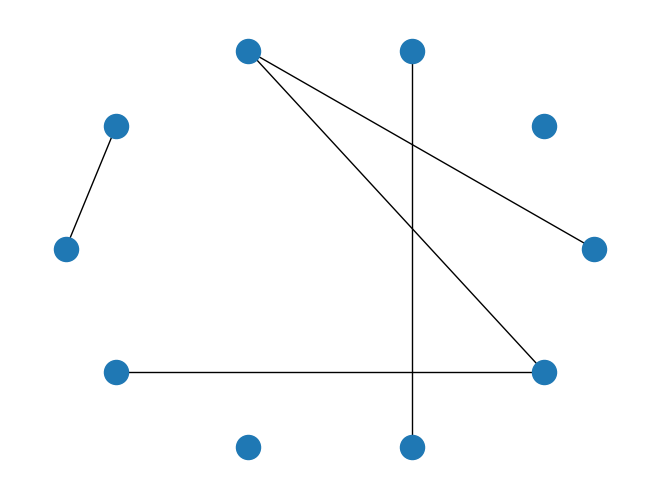

In [209]:
nx.draw_circular(small_word_graph.graph)

In [194]:
small_word_graph.graph.add_edges_from([(1, 2)])

1

In [32]:
a[chosen_indices]

array([[0, 2],
       [1, 2],
       [2, 0]])

In [185]:
small_word_graph.graph.edges

EdgeView([(0, 1), (0, 19), (0, 2), (0, 18), (1, 2), (1, 3), (1, 19), (2, 3), (2, 4), (3, 4), (3, 5), (4, 5), (4, 6), (5, 6), (5, 7), (6, 7), (6, 8), (7, 8), (7, 9), (8, 9), (8, 10), (9, 10), (9, 11), (10, 11), (10, 12), (11, 12), (11, 13), (12, 13), (12, 14), (13, 14), (13, 15), (14, 15), (14, 16), (15, 16), (15, 17), (16, 17), (16, 18), (17, 18), (17, 19), (18, 19)])

In [186]:
set(small_word_graph.graph.edges)

{(0, 1),
 (0, 2),
 (0, 18),
 (0, 19),
 (1, 2),
 (1, 3),
 (1, 19),
 (2, 3),
 (2, 4),
 (3, 4),
 (3, 5),
 (4, 5),
 (4, 6),
 (5, 6),
 (5, 7),
 (6, 7),
 (6, 8),
 (7, 8),
 (7, 9),
 (8, 9),
 (8, 10),
 (9, 10),
 (9, 11),
 (10, 11),
 (10, 12),
 (11, 12),
 (11, 13),
 (12, 13),
 (12, 14),
 (13, 14),
 (13, 15),
 (14, 15),
 (14, 16),
 (15, 16),
 (15, 17),
 (16, 17),
 (16, 18),
 (17, 18),
 (17, 19),
 (18, 19)}